In [1]:
import csv
import tensorflow as tf
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [3]:
# dataset from https://www.kaggle.com/shaneysze/new-york-city-daily-temperature-18692021
time_step = []
temp_max = []
data_sample = 12000

with open('/content/sample_data/nyc_temp_1869_2021.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temp_max.append(float(row[5]))
    time_step.append(int(row[0]))

series = np.array(temp_max[:data_sample])

In [4]:
# Normalization Function
min = np.min(series)
max = np.max(series)
series -= min
series /= max
time = np.array(time_step[:data_sample])

In [5]:
x_train = series[:int(len(series)*0.8)] 
x_valid = series[int(len(series)*0.8):] 

In [6]:
print(len(x_train))
print(len(x_valid))

9600
2400


In [7]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
validation_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(9600,)


In [9]:
model = tf.keras.models.Sequential([
        # YOUR CODE HERE.
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [11]:
save_model = '/content/sample_data/model.h5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
modelCheckpoint = ModelCheckpoint(save_model, save_best_only=True, monitor='val_mae', mode='min', verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min')

In [12]:
history = model.fit(train_set,
                    validation_data=validation_set,
                    epochs=60,
                    verbose=1,
                    callbacks=[earlyStopping, modelCheckpoint, reducelr])

Epoch 1/60
300/300 [==============================] - 7s 11ms/step - loss: 0.2010 - mae: 0.5670 - val_loss: 0.1069 - val_mae: 0.4016

Epoch 00001: val_mae improved from inf to 0.40161, saving model to /content/sample_data/model.h5
Epoch 2/60
300/300 [==============================] - 3s 9ms/step - loss: 0.0414 - mae: 0.2344 - val_loss: 0.0235 - val_mae: 0.1827

Epoch 00002: val_mae improved from 0.40161 to 0.18267, saving model to /content/sample_data/model.h5
Epoch 3/60
300/300 [==============================] - 3s 9ms/step - loss: 0.0218 - mae: 0.1760 - val_loss: 0.0211 - val_mae: 0.1721

Epoch 00003: val_mae improved from 0.18267 to 0.17209, saving model to /content/sample_data/model.h5
Epoch 4/60
300/300 [==============================] - 3s 9ms/step - loss: 0.0200 - mae: 0.1678 - val_loss: 0.0194 - val_mae: 0.1642

Epoch 00004: val_mae improved from 0.17209 to 0.16421, saving model to /content/sample_data/model.h5
Epoch 5/60
300/300 [==============================] - 3s 9ms/step -

In [15]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Visualization Model Training
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    epoch_number = range(len(acc))
    plt.figure(figsize=(6, 6), dpi=100)
    plt.subplot(2,1,1)
    plt.plot(epoch_number, acc, 'r', label='train mae')
    plt.plot(epoch_number, val_acc, 'b', label='val mae')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(epoch_number, loss, 'r', label='train loss')
    plt.plot(epoch_number, val_loss, 'b', label='val loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.show()

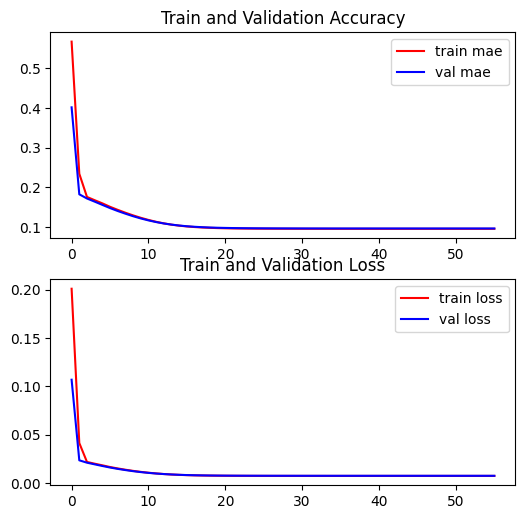

In [16]:
train_visualitation = plot_acc_loss(history)